### 0.1 Import Package

In [1]:
import os
import re
import sys
import copy
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import utils
from torchvision import datasets, models, transforms
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

device = torch.device("cuda:0")

PyTorch Version:  2.1.0+cu121
Torchvision Version:  0.16.0+cu121


### 0.2. Directory Setting

In [2]:
# from model.models import Conv4
from model.pretrained_models import get_pretrain_model
from dataset_dir.datasets import datasetload

In [3]:
MODEL_DIR = "./model/weight/"
LOG_DIR = "./results/log/"

**Specific model setting**: 특정한 모델을 확인하기 위해

In [4]:
RECURSIVE = False

conf = dict(
    epoch=100,
    lr=0.001,
    stepsize=50,
    gamma=0.1,
    model="alexnet",
    dataset="cifar10",
    pretrain=False,
    mode="cus",
    freeze="01011"
)
setting = "epoch"+str(conf['epoch'])+"_lr"+str(conf['lr'])

if conf["pretrain"] :
    name = "pretrain/"+str(conf['model'])+"/"+str(conf['dataset'])+"_"+setting
else :
    if str(conf["mode"]) == "cus":
        setting += "_freeze"+str(conf['freeze'])+"111"
        name = "custom/"+str(conf['model'])+"/"+str(conf['dataset'])+"_"+setting
    else :
        name = "optimal/"+str(conf['model'])+"/"+str(conf['dataset'])+"_"+setting
model_path = MODEL_DIR + name +".pt"
log_path = LOG_DIR +  name


print(model_path)
print(log_path)

./model/weight/custom/alexnet/cifar10_epoch100_lr0.001_freeze01011111.pt
./results/log/custom/alexnet/cifar10_epoch100_lr0.001_freeze01011111


**Entire model setting**: directory에 저장되어있는 전체 모델을 확인하기 위해

In [5]:
RECURSIVE = True

MODEL_DIR += "custom/alexnet/"
LOG_DIR += "custom/alexnet/"


weight_files = [os.path.join(MODEL_DIR, file) for file in os.listdir(MODEL_DIR) if os.path.isfile(os.path.join(MODEL_DIR, file))]
log_files = [os.path.join(LOG_DIR, file) for file in os.listdir(LOG_DIR)]

print(len(weight_files))
print(weight_files[0])
print(len(log_files))
print(log_files[0])

26
./model/weight/custom/alexnet/cifar100_epoch100_lr0.001_freeze01011111.pt
26
./results/log/custom/alexnet/cifar100_epoch100_lr0.001_freeze01011111


In [6]:
from utils.util_functions import name_parser

mode, model, dataset, freeze = name_parser(weight_files[0])
print(mode, model, dataset, freeze)

custom alexnet cifar100 01011111


In [7]:
SAVE = False

# 1. Architecture
특정 데이터셋, 모델의 구조를 확인하기 위한 코드. RECURSIVE하게 모든 weight파일에 대해서 동작하지 않습니다.

In [8]:
trainloader, validloader, testloader, num_class = datasetload(conf['dataset'])
model = get_pretrain_model(conf['model'], num_class)
model_state = torch.load(model_path)
model.load_state_dict(model_state)

Files already downloaded and verified
Files already downloaded and verified


<All keys matched successfully>

### 1.1 Model Architecture

In [9]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
summary(model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [11]:
from utils.util_functions import get_alias
layer_name_list = ['features.0', 'features.3', 'features.6', 'features.8', 'features.10']
model_info = dict(
    conv1=0,
    conv2=3,
    conv3=6,
    conv4=8,
    conv5=10
)

print(get_alias(layer_name_list[0], model_info))

conv1


### 1.2 Dataset Property

In [12]:
print(num_class)
print(len(trainloader.dataset))
print(len(testloader.dataset))

10
40000
10000


In [13]:
from utils.visualize_tool import visualize_tensor

torch.Size([3, 224, 224])


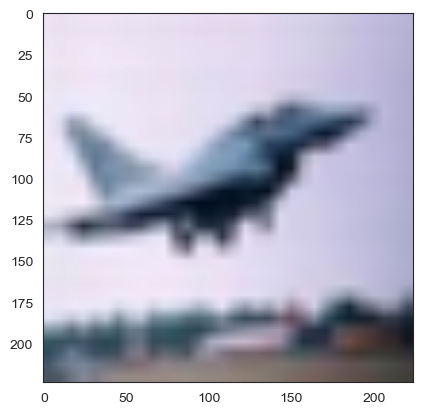

In [14]:
image = trainloader.dataset[0][0]
print(image.shape)

sns.set_style("white")
visualize_tensor(image)

### 1.3 Train Log Print

In [ ]:
def draw_log(path, isSave=False, overlap=True):
    mode, model, dataset, freeze = name_parser(path)
    event_acc = EventAccumulator(path)
    event_acc.Reload()

    if 'scalars' in event_acc.Tags():
        scalar_tags = event_acc.Tags()['scalars']

        if not overlap :
            plt.figure(figsize=(13, 10))
            sns.set()

        for i, tag in enumerate(scalar_tags):
            values = event_acc.Scalars(tag)
            steps = [v.step for v in values]
            data = [v.value for v in values]
            
            df = pd.DataFrame({'Step': steps, tag: data})

            plt.subplot(2, 2, i + 1)
            sns.lineplot(x='Step', y=tag, data=df, label=dataset+"("+freeze+")" )
            plt.xlabel('Steps')
            plt.ylabel(tag)
            plt.title(f'{tag} over Time')
            
        plt.tight_layout()
        if not overlap :
            plt.show()

if not RECURSIVE :
    draw_log(log_path, SAVE)

else :
    plt.figure(figsize=(13, 10))
    sns.set()
    for log_path in log_files :
        draw_log(log_path, SAVE)
    plt.show()

# 2. Visualization

### 2.1. cnn Filter visualization
`visualize_filters` : 모델을 이루는 각각의 convolution 필터의 가중치를 시각화 합니다. (constraint: 1st channel)

In [17]:
from utils.visualize_tool import visualize_filters

In [15]:
layer_names = [name for name, _ in model.named_modules()]
print(layer_names)

['', 'features', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'classifier', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


torch.Size([64, 3, 11, 11])


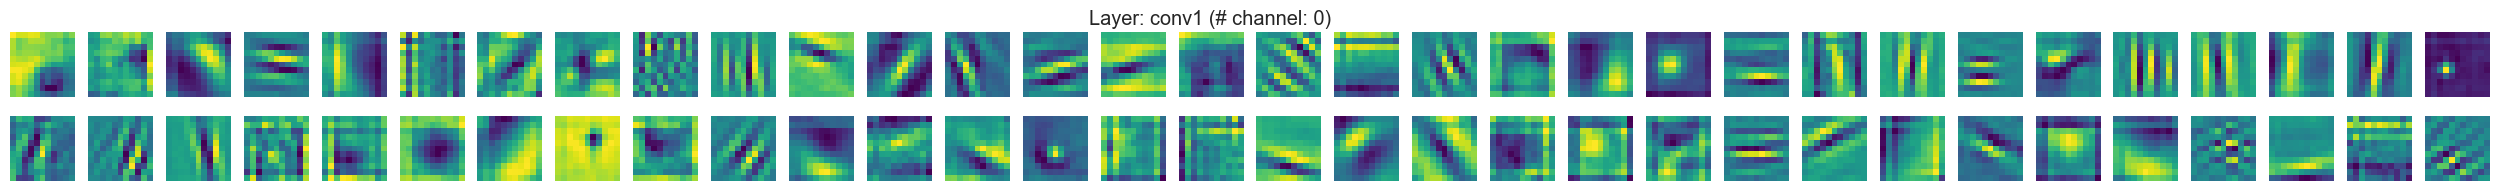

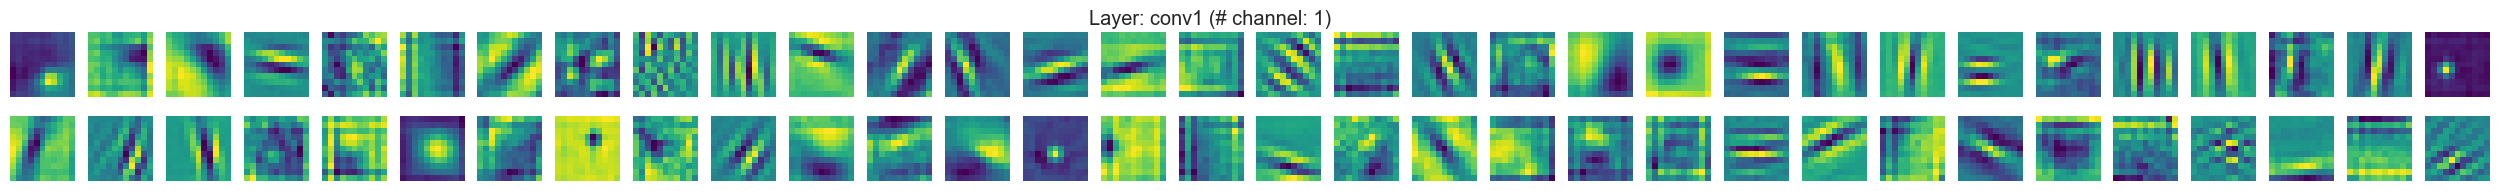

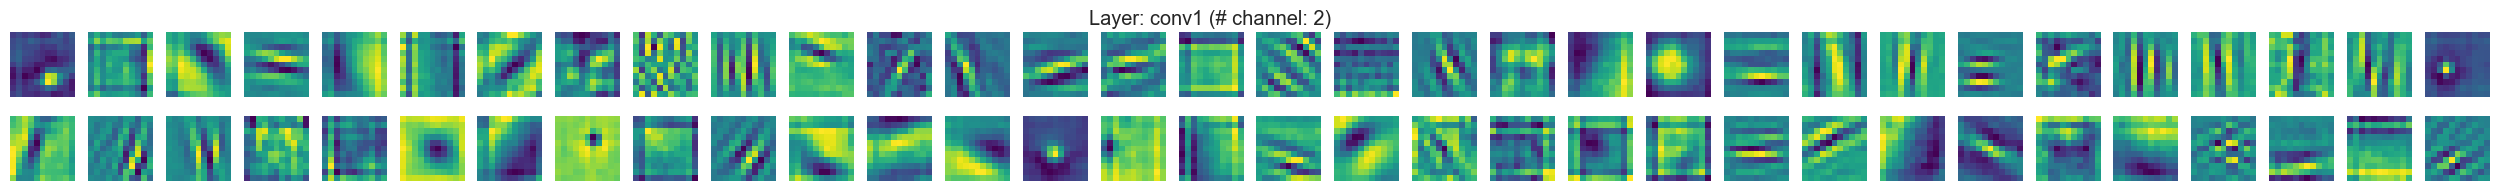

In [19]:
layer_name = "features.0"
visualize_filters(model, layer_name, ncols=32, nchannel=5, showAll=False)

In [ ]:
""" RECURSIVE : Running This!!! """
layer_name_list = ['features.0', 'features.3', 'features.6', 'features.8', 'features.10']

for name in layer_name_list :
    visualize_filters(model, layer_name, ncols=32, nchannel=5, showAll=False)

### 2.2. Feature map Visualize
`visualize_feature_map` : 특정 입력 이미지에 대해 모델의 각 레이어를 통과했을 때 feature_map을 시각화 합니다. (constraint: 1st feature map)

torch.Size([192, 27, 27])


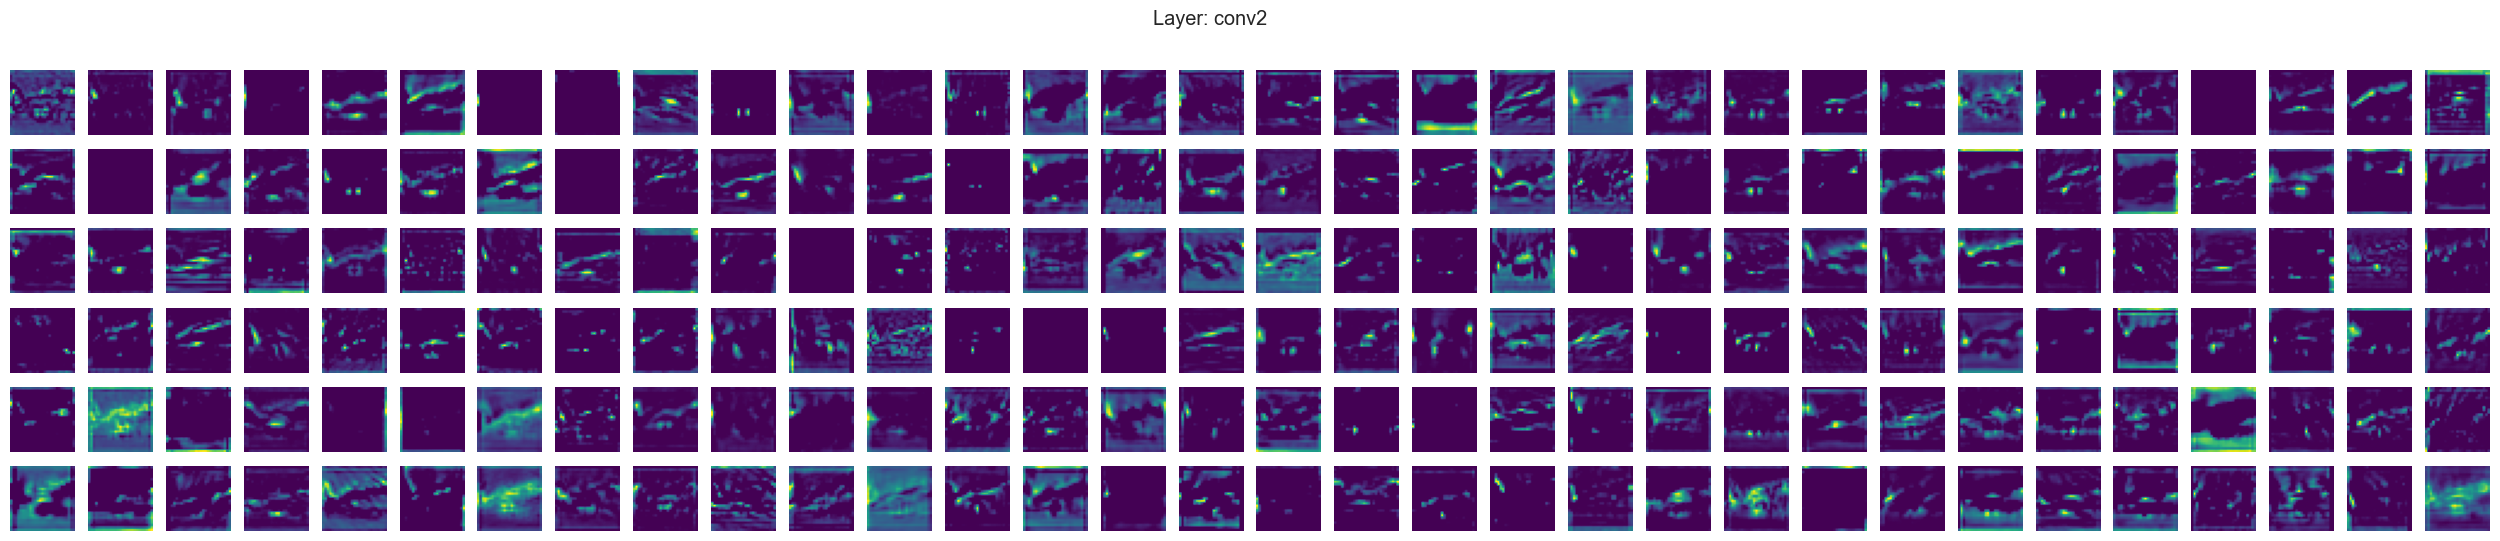

In [21]:
from utils.visualize_tool import visualize_feature_map

layer_name = 'conv2'
input_image = torch.unsqueeze(image, 0)

activation = {}
visualize_feature_map(model, input_image, layer_name, model_info[layer_name])

In [ ]:
""" RECURSIVE : Running This!!! """
model_info = dict(
    conv1=0,
    conv2=3,
    conv3=6,
    conv4=8,
    conv5=10
)

input_image = torch.unsqueeze(image, 0)

for layer_name in model_info:
    activation = {}
    visualize_feature_map(model, input_image, layer_name, model_info[layer_name])

### 2.3. weight distribution (each layer)
`visualize_weight_distribution` : 모델을 이루는 각각의 레이어의 가중치 분포를 시각화 합니다. 

In [15]:
from utils.visualize_tool import visualize_weight_distribution

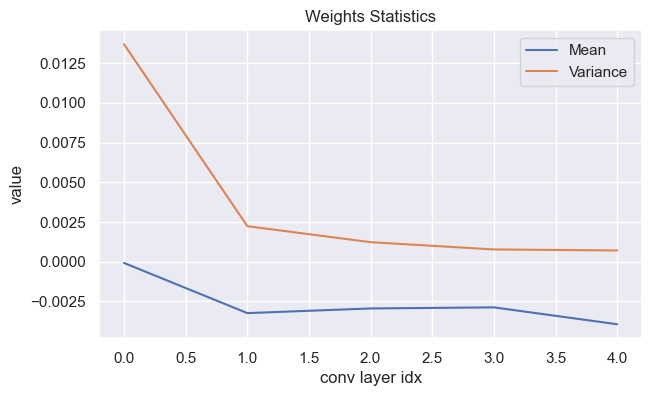

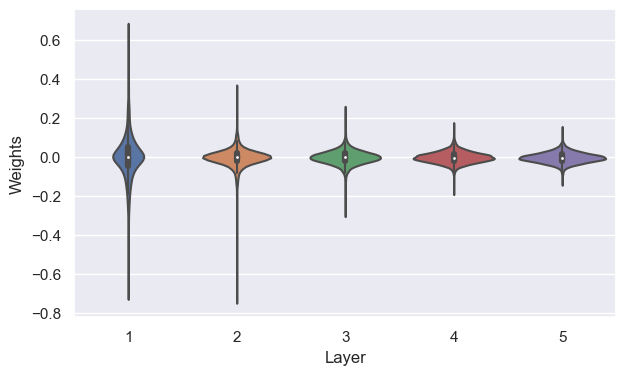

In [17]:
visualize_weight_distribution(model, violin_sample=5000)

### 2.4. Dataset Distribution
``: 모델이 판단하는 CLASS와 실제 정답 CLASS의 분포를 비교합니다.

### 2.5. Gradient

In [18]:
from PIL import Image
import matplotlib.cm as mpl_color_map
from matplotlib.colors import ListedColormap
from torch.autograd import Variable

def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr


def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)

def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on image
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def apply_heatmap(R, sx, sy):
    """
        Heatmap code stolen from https://git.tu-berlin.de/gmontavon/lrp-tutorial

        This is (so far) only used for LRP
    """
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:, 0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    plt.figure(figsize=(sx, sy))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.axis('off')
    heatmap = plt.imshow(R, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    return heatmap
    # plt.show()
    
def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs

    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # Mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

**2.5.1 Layer-CAM**  
LayerCAM [16] is a simple modification of Grad-CAM [3], which can generate reliable class activation maps from different layers.  
``: 모델이 이미지를 분류할 떄, 어떤 부분에 집중하여 판단하는지를 함께 표현하여 시각화합니다.

In [19]:

class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


class LayerCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        # Get convolution outputs
        target = conv_output.data.numpy()[0]
        # Get weights from gradients
        weights = guided_gradients
        weights[weights < 0] = 0 # discard negative gradients
        # Element-wise multiply the weight with its conv output and then, sum
        cam = np.sum(weights * target, axis=0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255

        return cam

In [27]:
from PIL import Image
from utils.util_functions import tensor_to_img

tensor_img = trainloader.dataset[0][0].numpy().transpose(1, 2, 0)
original_image = tensor_to_img(tensor_img)
target_class = trainloader.dataset[0][1]
print(original_image.shape, target_class)

print(type(original_image))
prep_img = preprocess_image(original_image)
layer_cam = LayerCam(model, target_layer=0)
cam = layer_cam.generate_cam(prep_img, target_class)

(224, 224, 3)


TypeError: Cannot handle this data type: (1, 1, 3), <f4

**2.5.2 Grad Times Image**  
Another technique that is proposed is simply multiplying the gradients with the image itself.  
``: 모델이 주어진 이미지를 볼 때, 계산된 Gradient와 원본이미지의 곱으로 나타낸 그림을 시각화합니다.

In [ ]:
class VanillaBackprop():
    """
        Produces gradients generated with vanilla back propagation from the image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        # Hook the first layer to get the gradient
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

def visualize_grad_times_image(image, prep_img, target_class, model):
    #target_example = 0
    #(original_image, prep_img, target_class, file_name_to_export, pretrained_model) = get_example_params(target_example)
    # Vanilla backprop
    VBP = VanillaBackprop(model)
    # Generate gradients
    vanilla_grads = VBP.generate_gradients(prep_img, target_class)

    # Make sure dimensions add up!
    grad_times_image = vanilla_grads * prep_img.detach().numpy()[0]
    # Convert to grayscale
    grayscale_vanilla_grads = convert_to_grayscale(grad_times_image)
    # Save grayscale gradients
    save_gradient_images(grayscale_vanilla_grads,
                         file_name_to_export + '_Vanilla_grad_times_image_gray')
    print('Grad times image completed.')


# 3. Comparison

### 3.1. Train Accuracy
- ``: 각 데이터셋 마다 layer freezing에 따른 train accuracy를 비교합니다.
- ``: 각 layer freezing마다 데이터셋에 따른 train accuracy를 비교합니다.

### 3.2. Test Accuracy
- ``: 각 데이터셋 마다 layer freezing에 따른 test accuracy를 비교합니다.
- ``: 각 layer freezing마다 데이터셋에 따른 test accuracy를 비교합니다.